**Question 1:** Estimate the forecasted total production of Wheat or Canola for the year 2025 in Winnipeg and its surround areas. Show all thought processes and any supporting claims of data that leads up to your answer.

> I chose to focus on **wheat production** for this question.

In [83]:
# Import libraries. I would normally write a requirements.txt but this is going to be used on another PC.

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.linear_model import LinearRegression

**1. Data Collection and Preprocessing**

>**a. Gathered Manitoba wheat production data from Statistics Canada**
>>Source: Table 32-10-0359-01  Estimated areas, yield, production, average farm price and total farm value of principal field crops, in metric and imperial units

>**b. Clean column data types**
>>Year = int\
Seeded_area = int\
Harvested_area = int\
Average_yield = float\
Production = int


In [84]:
cd = os.getcwd()
file = cd[:-7] + 'Data/Wheat data Statistics Canada.csv' # Change so this works in folder structure for another PC.
wheat_df = pd.read_csv(file)

wheat_df['Seeded_area (acres)'] = wheat_df['Seeded_area (acres)'].str.replace(',', '').astype(int)
wheat_df['Harvested_area (acres)'] = wheat_df['Harvested_area (acres)'].str.replace(',', '').astype(int)
wheat_df['Production (metric tonnes)'] = wheat_df['Production (metric tonnes)'].str.replace(',', '').astype(int)

conversion_factor = 0.011009
wheat_df['Average_yield (tonnes per hectare)'] = wheat_df['Average_yield (bushels per acre)'] * conversion_factor

wheat_df = wheat_df.rename(columns = {'Seeded_area (acres)': 'Seeded_area', 'Harvested_area (acres)': 'Harvested_area', 'Production (metric tonnes)': 'Production', 
                                      'Average_yield (tonnes per hectare)': 'Average_yield', 'Reference_period': 'Year'})

wheat_df = wheat_df[['Year', 'Seeded_area', 'Harvested_area', 'Average_yield', 'Production']]

display(wheat_df.head(5))

,Year,Seeded_area,Harvested_area,Average_yield,Production
0,1994,4105000,4095000,0.365499,3696600
1,1995,4020000,3990000,0.345683,3404700
2,1996,4225000,4200000,0.421645,4376500
3,1997,3890000,3880000,0.348985,3350200
4,1998,3245000,3230000,0.402929,3219700


**c. Handle missing values or outliers**
> I put together the small dataset so I already know there are no missing values or issues with the data. Otherwise, I would investigate in this step.

In [85]:
summary = wheat_df.describe()
print(summary)

              Year   Seeded_area  Harvested_area  Average_yield    Production
count    30.000000  3.000000e+01    3.000000e+01      30.000000  3.000000e+01
mean   2008.500000  3.283693e+06    3.212518e+06       0.503258  3.944528e+06
std       8.803408  4.449307e+05    4.662169e+05       0.112893  8.017690e+05
min    1994.000000  2.217000e+06    2.125000e+06       0.345683  2.228900e+06
25%    2001.250000  3.025000e+06    2.915550e+06       0.410085  3.363825e+06
50%    2008.500000  3.177500e+06    3.120000e+06       0.489900  3.860250e+06
75%    2015.750000  3.391250e+06    3.326500e+06       0.572193  4.352600e+06
max    2023.000000  4.225000e+06    4.200000e+06       0.679255  5.451483e+06


**2. Exploratory Data Analysis**
> Objective is to understand the data distribution, trends, and seasonality through visualizations.


**a. Histogram**
> The data has a fairly normal distribution in its raw state meaning we can use time-series or regression models without much effort.

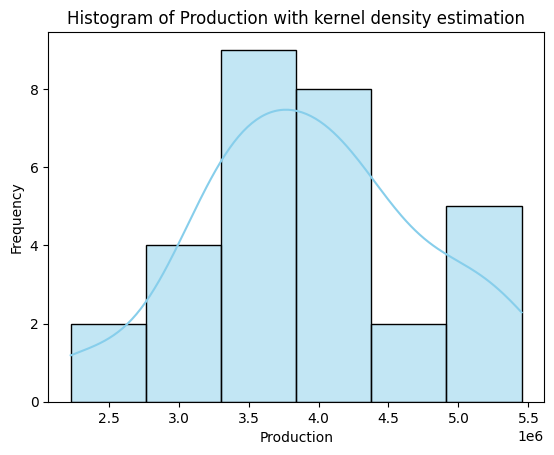

In [ ]:
production_data = wheat_df['Production']

sns.histplot(production_data, kde = True, bins = 6, color = 'skyblue') # I chose 6 bins since there is only 30 records (square root rule).

plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title('Histogram of Production with kernel density estimation')
plt.show()

**b. Line Plot**
> Production values exhibit fluctuations, so a time series model may be appopriate.

Text(0.5, 1.0, 'Yearly Whear Production (2024 not complete)')

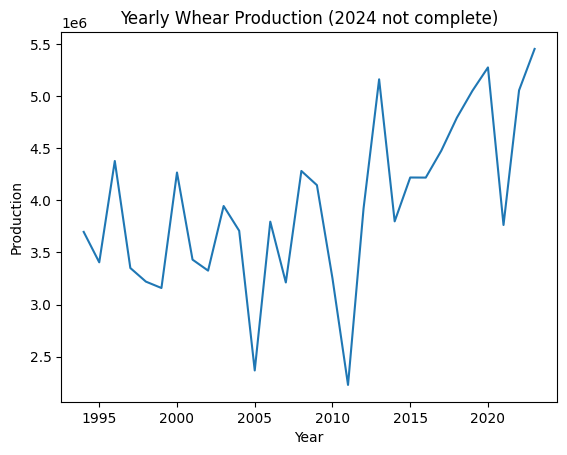

In [87]:
line_plot_data = wheat_df[['Year', 'Production']]

sns.lineplot(data = line_plot_data, x = 'Year', y = 'Production')

plt.xlabel('Year')
plt.ylabel('Production')
plt.title('Yearly Whear Production (2024 not complete)')

**c. Autocorellation Analysis (ACF and PACF)**
> I decided not to proceed with a time-series model, like an ARIMA, since the autocorrelation functions drop off significantly after 1 lag. This indicates the time series may not have a strong temporal structure to model especially as large drops in production like 2011 can occur.\
I believe creating a model based on independant predictors vs autocorrelation will be more accurate.

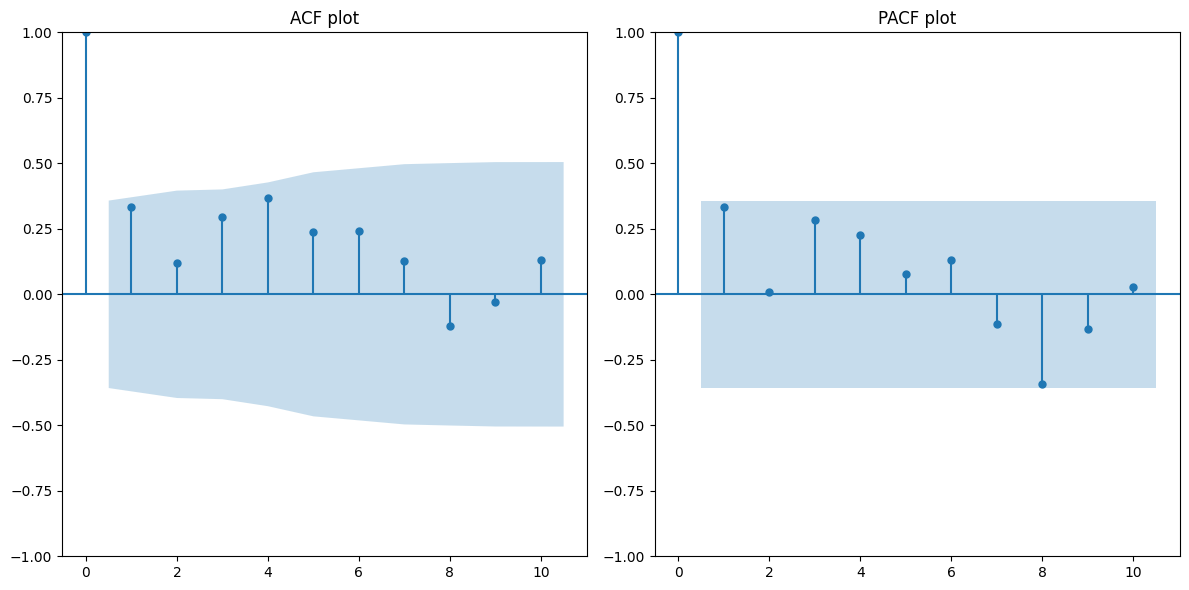

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_acf(production_data, lags = 10, ax = plt.gca())
plt.title('ACF plot')

plt.subplot(1, 2, 2)
plot_pacf(production_data, lags = 10, ax = plt.gca())
plt.title('PACF plot')

plt.tight_layout()
plt.show()


**d. Scatter Plots (Seeded Area, Harvested Area and Average Yield)**
> Statistics Canada provided three features that seemed promissing: Seeded Area, Harvested Area and Average Yield.\
Surprisingly, it looks like Seeded and Harvested Areas do not have strong relationships with Production from 1994 to 2023. The relationship with Average Yield is fairly strong.\
If necessary, I will find a period to make Harvested Area work (such as 2011 to 2023), however, we already have a very small dataset so ideally we will not reduce it further.

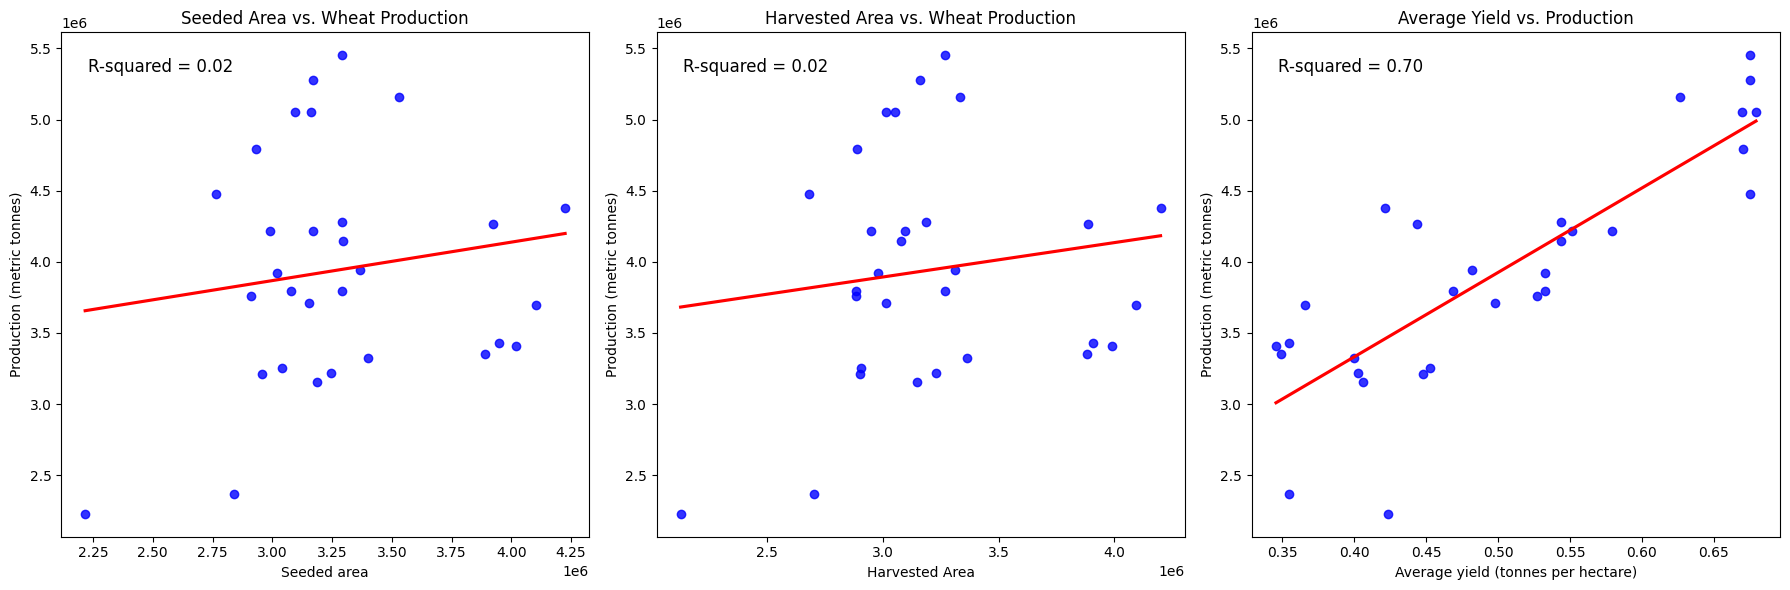

In [100]:
def calculate_r_squared(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    return model.score(x.reshape(-1, 1), y)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.regplot(x='Seeded_area', y='Production', data=wheat_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None, ax=axes[0])
r2_1 = calculate_r_squared(wheat_df['Seeded_area'].values, wheat_df['Production'].values)
axes[0].text(0.05, 0.95, f'R-squared = {r2_1:.2f}', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')
axes[0].set_title("Seeded Area vs. Wheat Production")
axes[0].set_xlabel("Seeded area")
axes[0].set_ylabel("Production (metric tonnes)")

sns.regplot(x='Harvested_area', y='Production', data=wheat_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None, ax=axes[1])
r2_2 = calculate_r_squared(wheat_df['Harvested_area'].values, wheat_df['Production'].values)
axes[1].text(0.05, 0.95, f'R-squared = {r2_2:.2f}', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')
axes[1].set_title("Harvested Area vs. Wheat Production")
axes[1].set_xlabel("Harvested Area")
axes[1].set_ylabel("Production (metric tonnes)")

sns.regplot(x='Average_yield', y='Production', data=wheat_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None, ax=axes[2])
r2_3 = calculate_r_squared(wheat_df['Average_yield'].values, wheat_df['Production'].values)
axes[2].text(0.05, 0.95, f'R-squared = {r2_3:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='top')
axes[2].set_title("Average Yield vs. Production")
axes[2].set_xlabel("Average yield (tonnes per hectare)")
axes[2].set_ylabel("Production (metric tonnes)")


plt.tight_layout()
plt.show()

**3. Feature and Model Selection**
>Objective: Choose the right features and model to predict 2025 wheat production.

**a. Feature Selection**
>First, I wanted to check the features for multicollinearity because I highly suspected Seeded and Harvested Areas would be highly correlated.\
As displayed in the following correlation matrix, this is the case as they share a correlation of 0.99.\
I will rely on this matrix for dimension reduction since this is a short assignment and we are already limited on features.\
We will try to build a model using Harvested Area and Average Yield.

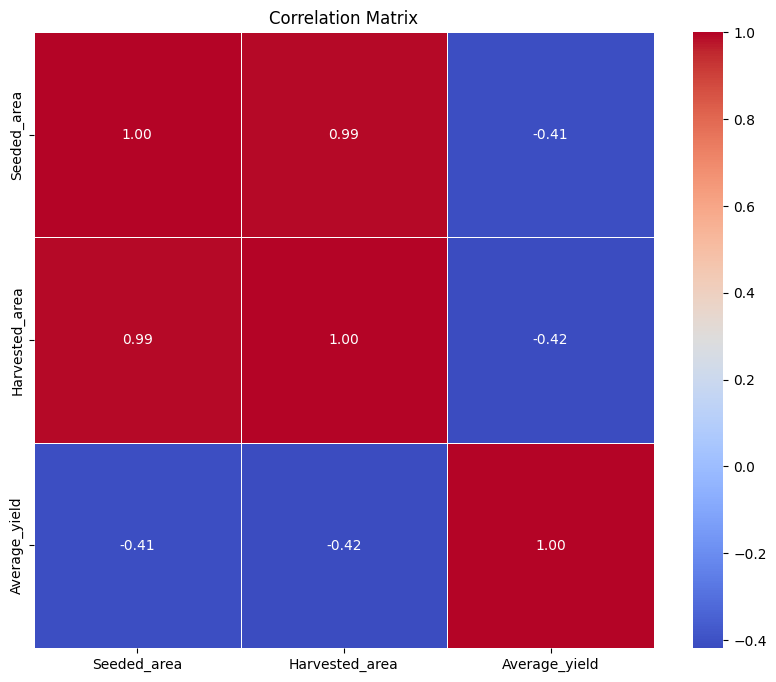

In [101]:
correlation_data = wheat_df[['Seeded_area', 'Harvested_area', 'Average_yield']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()

**b. Model Selection**
>Our data has only a couple dimensions so this limits our selection of appropriate models: Multiple Linear Regression or Gradient Boosting.\
I elected to pursue a Gradient Boosting model since I am not confident there is a linear relationship between Harvested Area and Production, per 2d.

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split

X = wheat_df[['Harvested_area', 'Average_yield']]
y = wheat_df['Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

print("Cross-Validation R-squared Scores:", cv_scores)
print("Mean R-squared:", cv_scores.mean())

Cross-Validation R-squared Scores: [0.90649289 0.09210155 0.82466886 0.87224707 0.38217101]
Mean R-squared: 0.6155362742425499


**c. Hyperparameter Tuning**
>There was a very small performance gain from hypertuning the parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation R-squared:", grid_search.best_score_)

model_best = GradientBoostingRegressor(n_estimators = 300, learning_rate = 0.1, max_depth = 3, random_state = 42)
model_best.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Cross-validation R-squared: 0.6156881107025307


**2025 Wheat Production Forecast**
> I set the 2025 predictors to remain the same as 2024 values.\
I found an article where the Director of Market Intelligence and Trade Policy with Cereals Canada estimates the seeded area for wheat will be similar in 2025.\
Source: https://discoverwestman.com/articles/2024-canadian-wheat-crop-report-highlights-strong-year-for-prairie-farmers-

In [123]:
predict_df = pd.DataFrame(
    {   
        'Harvested_area': [3199000],
        'Average_yield': [0.6286 ]
    }
)

prediction_2025 = model_best.predict(predict_df)
prediction_2025 = str(prediction_2025[0].round(0))

print("Predicted Manitoba Wheat Production for 2025:", prediction_2025, 'metric tonnes')

Predicted Manitoba Wheat Production for 2025: 5181383.0 metric tonnes


**Conclusion**
> Assuming average yield and seeded area (also affecting harvested area) remain similar in 2025 compared to the 2024 season, I would estimate Manitoba's wheat production to be near **5,181,383 metric tonnes** in 2025. 

**Question 2:** Use this source for hourly temperature data for the day we find the max temperature: https://www.wunderground.com/history/daily/us/ri/KPVD/date/2024-10-1